<a href="https://colab.research.google.com/github/jackrlynn3/capstone-diabetes/blob/main/models/deep-learning/diabetes_DL_width_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Prediction of Blood Glucose Sharp Peaks:** Width Test
## **Test**: Determine the Optimal Width of Training Points (i.e., number of previous steps to consider)

In [8]:
# Downloads
! pip install pymssql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# Imports
import numpy as np
import pymssql
import pandas as pd
import matplotlib.pyplot as plt
from getpass import getpass
import datetime as dt
from datetime import timedelta
import time
from scipy.signal import savgol_filter, find_peaks
import time
import random as r
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import matplotlib
from google.colab import drive

### **Part 1:** Set-Up of Dataset
*Contact Jack Lynn (jackrlynn@gmail.com) for log-in credentials.*

In [10]:
# Get dataset
def getData(database, table, server, port):

    # Get username and password
    username = input('Please enter username: ')
    password = getpass('Please enter password: ')

    conn = pymssql.connect(server,username,password,database)
    cursor = conn.cursor()
    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query,conn)
    return df

df = getData("group5database", "dbo.GlucoseMeter",
             "gen10-data-fundamentals-22-05-sql-server.database.windows.net",
             "1433")

Please enter username: jacklynn
Please enter password: ··········


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Text(0, 0.5, 'Blood Glucoose (mmol/L)')

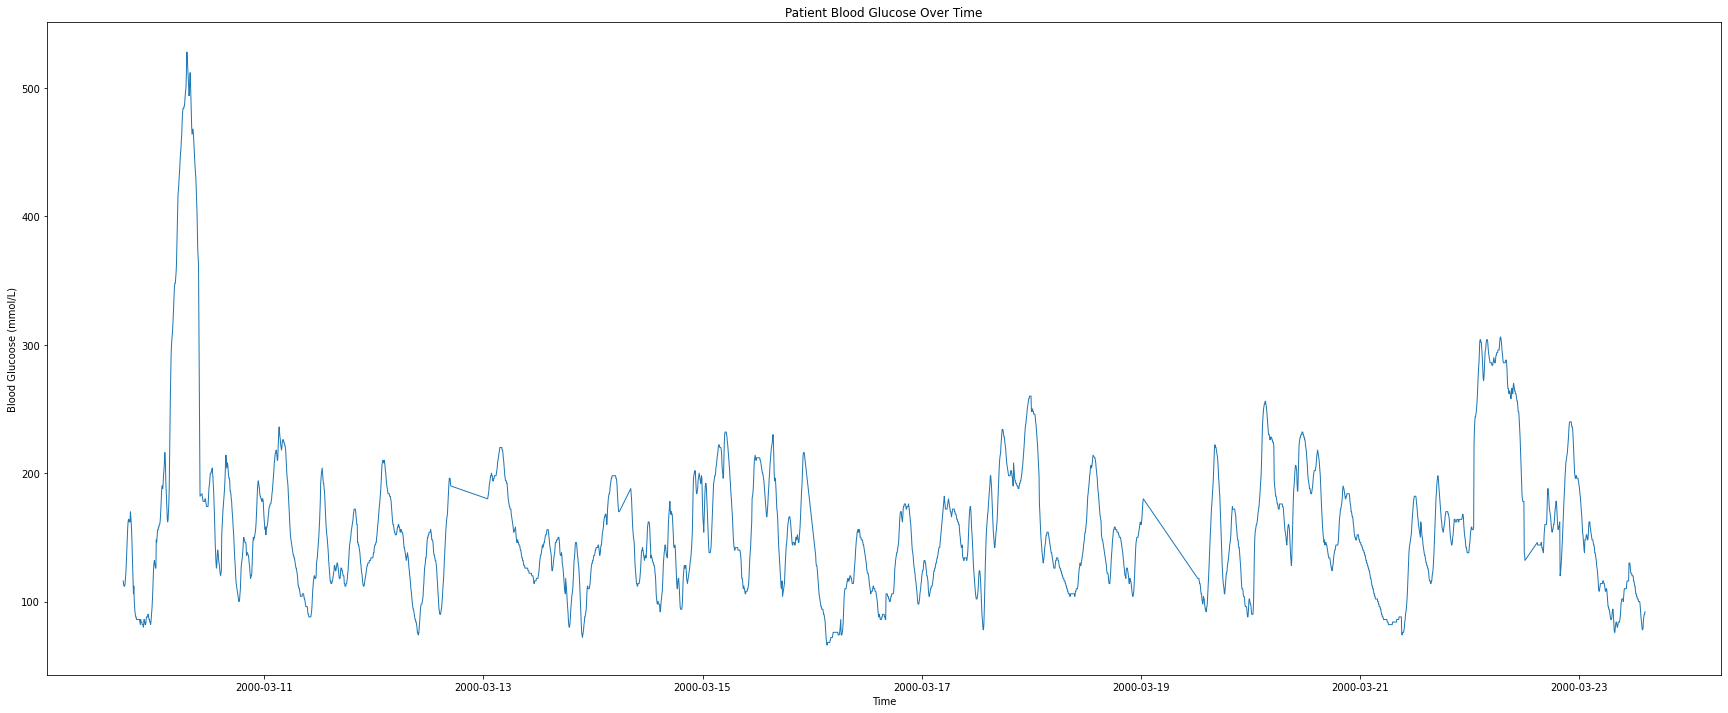

In [11]:
# Display static graphs
%matplotlib inline

# Get each patient
pts = dict()
for ptID in df['ptID'].unique():
  this_df = df[df['ptID'] == ptID]

  # Get only data related to time and glucose_lvl
  this_df = this_df[['time', 'glucose_lvl']]

  # Convert time back into dateime format
  this_df['time']= pd.to_datetime(this_df['time'])

  # Make sure time is in order
  this_df = this_df.sort_values('time')

  # Add patient to dictionary
  pts[ptID] = this_df

# Plot each patient on the same graph
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(pts[321]['time'], pts[321]['glucose_lvl'], LineWidth=1)
ax.set_title('Patient Blood Glucose Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Blood Glucoose (mmol/L)')

In [12]:
# Create list of individual DataFrames
df = pd.DataFrame()
for pt in pts.keys():

  # Format DataFrame
  this_df = pts[pt]
  this_df['pt'] = pt

  # Add to total DataFrame
  if (df.empty):
    df = this_df
  else:
    df = pd.concat([df, this_df], axis=0)

In [13]:
# Create models dictionary for saving tested models
models = dict()
predictions = dict()
timer = dict()

In [14]:
# Split train and test
def splitXandY(df, test_prop=0.2):

  # Create train-test split
  df_test_pts = r.choices(df['pt'].unique(), k=int(test_prop*len(df['pt'].unique())))
  df_train_pts = list(filter(lambda x : x not in df_test_pts, df['pt'].unique()))
  df_test = df.loc[df['pt'].isin(df_test_pts)]
  df_train = df.loc[df['pt'].isin(df_train_pts)]

  # Return split
  return [df_train, df_test]

In [15]:
# Prepare the data
df_train, df_test = splitXandY(df)
minMax = MinMaxScaler(feature_range=(-1, 1))
df_train = df_train.drop(columns=['time', 'pt'])
df_test = df_test.drop(columns=['time', 'pt'])

### **Part 2:** Train Different Window Sizes

In [17]:
for j in range(5, 51, 5):

  # Convert into 3D shape with window size preview
  window = j
  X = []
  y = []
  y_unf = df_train['glucose_lvl'].to_list()
  for i in range(window, len(df_train)):
    X.append(df_train.iloc[(i-window):i])
    y.append([y_unf[i]])
  X = np.array(X)
  y = np.array(y)
  X_test = []

  # Do the same for test frame
  y_test = []
  y_unf = df_test['glucose_lvl'].to_list()
  for i in range(window, len(df_test)):
    X_test.append(df_test.iloc[(i-window):i])
    y_test.append(y_unf[i])
  X_test = np.array(X)
  y_test = np.array(y)

  # Build the model
  # Initialize model
  model_i = keras.models.Sequential()

  # Add layers
  model_i.add(keras.layers.LSTM(units=50, return_sequences=True,
                              input_shape=(X.shape[1], X.shape[2])))
  model_i.add(keras.layers.Dense(25, activation='relu'))
  model_i.add(keras.layers.Dropout(0.2))
  model_i.add(keras.layers.LSTM(units=25, return_sequences=True))
  model_i.add(keras.layers.Dense(10, activation='relu'))
  model_i.add(keras.layers.Dropout(0.2))
  model_i.add(keras.layers.LSTM(units=10, return_sequences=True))
  model_i.add(keras.layers.Dense(5, activation='relu'))
  model_i.add(keras.layers.Dropout(0.2))
  model_i.add(keras.layers.LSTM(units=5, return_sequences=True))
  model_i.add(keras.layers.Flatten())
  model_i.add(keras.layers.Dense(1, activation='linear'))

  # Compile model with optimizer and loss function
  model_i.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mean_squared_error'])

  # Allow for early exit
  es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1,
                                    patience=10)

  print(f'Executing: {j} Window Size')

  # Start timer
  t_init = time.time()

  # Train model
  m = model_i.fit(X, y, epochs=10, batch_size=500, callbacks=[es])

  # Get prediction
  y_pred = m.model.predict(X_test)

  # End timer
  t_end = time.time()

  # Models
  models[f'Window Size {j}'] = m
  predictions[f'Window Size {j}'] = y_pred
  timer[f'Window Size {j}'] = t_end - t_init

Executing: 5 Window Size
Epoch 1/10
1277/1277 [==============================] - 25s 11ms/step - loss: 27989.4258 - mean_squared_error: 27989.4258
Epoch 2/10
1277/1277 [==============================] - 15s 12ms/step - loss: 19685.2637 - mean_squared_error: 19685.2637
Epoch 3/10
1277/1277 [==============================] - 14s 11ms/step - loss: 14077.4316 - mean_squared_error: 14077.4316
Epoch 4/10
1277/1277 [==============================] - 14s 11ms/step - loss: 10211.0459 - mean_squared_error: 10211.0459
Epoch 5/10
1277/1277 [==============================] - 17s 13ms/step - loss: 7781.7485 - mean_squared_error: 7781.7485
Epoch 6/10
1277/1277 [==============================] - 17s 13ms/step - loss: 6515.1055 - mean_squared_error: 6515.1055
Epoch 7/10
1277/1277 [==============================] - 13s 10ms/step - loss: 6052.1509 - mean_squared_error: 6052.1509
Epoch 8/10
1277/1277 [==============================] - 13s 10ms/step - loss: 5966.9185 - mean_squared_error: 5966.9185
Epoch 9

### **Part 3:** Visualizations

(0.0, 400.0)

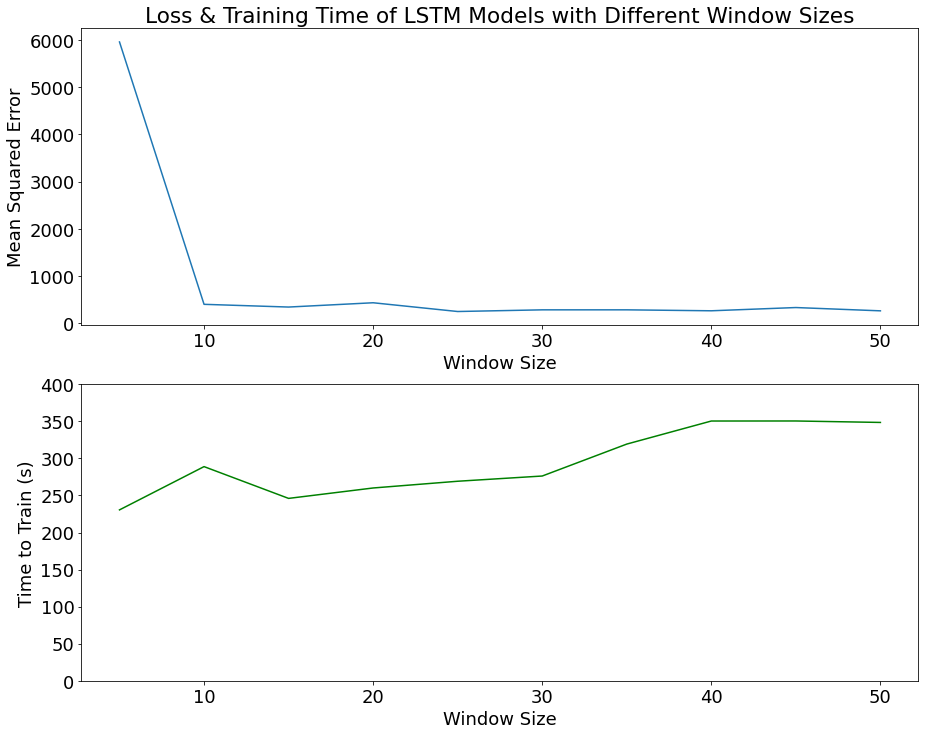

In [23]:
# Plot mean squared errors
fig, axs = plt.subplots(2, figsize=(15, 12))

# Get loss values
loss = list(map(lambda key : models[key].history['loss'][-1], models.keys()))
window_sizes = list(range(5, 51, 5))
times = list(map(lambda key : timer[key], timer.keys()))

# Plot these values
axs[0].plot(window_sizes, loss)
axs[1].plot(window_sizes, times, color='green')

# Add in plot features
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
axs[0].set_title('Loss & Training Time of LSTM Models with Different Window Sizes')
axs[0].set_xlabel('Window Size')
axs[0].set_ylabel('Mean Squared Error')

# Add in plot features
#axs[1].set_title('Training Times of Models with Different Window Size')
axs[1].set_xlabel('Window Size')
axs[1].set_ylabel('Time to Train (s)')
axs[1].set_ylim([0, 400])

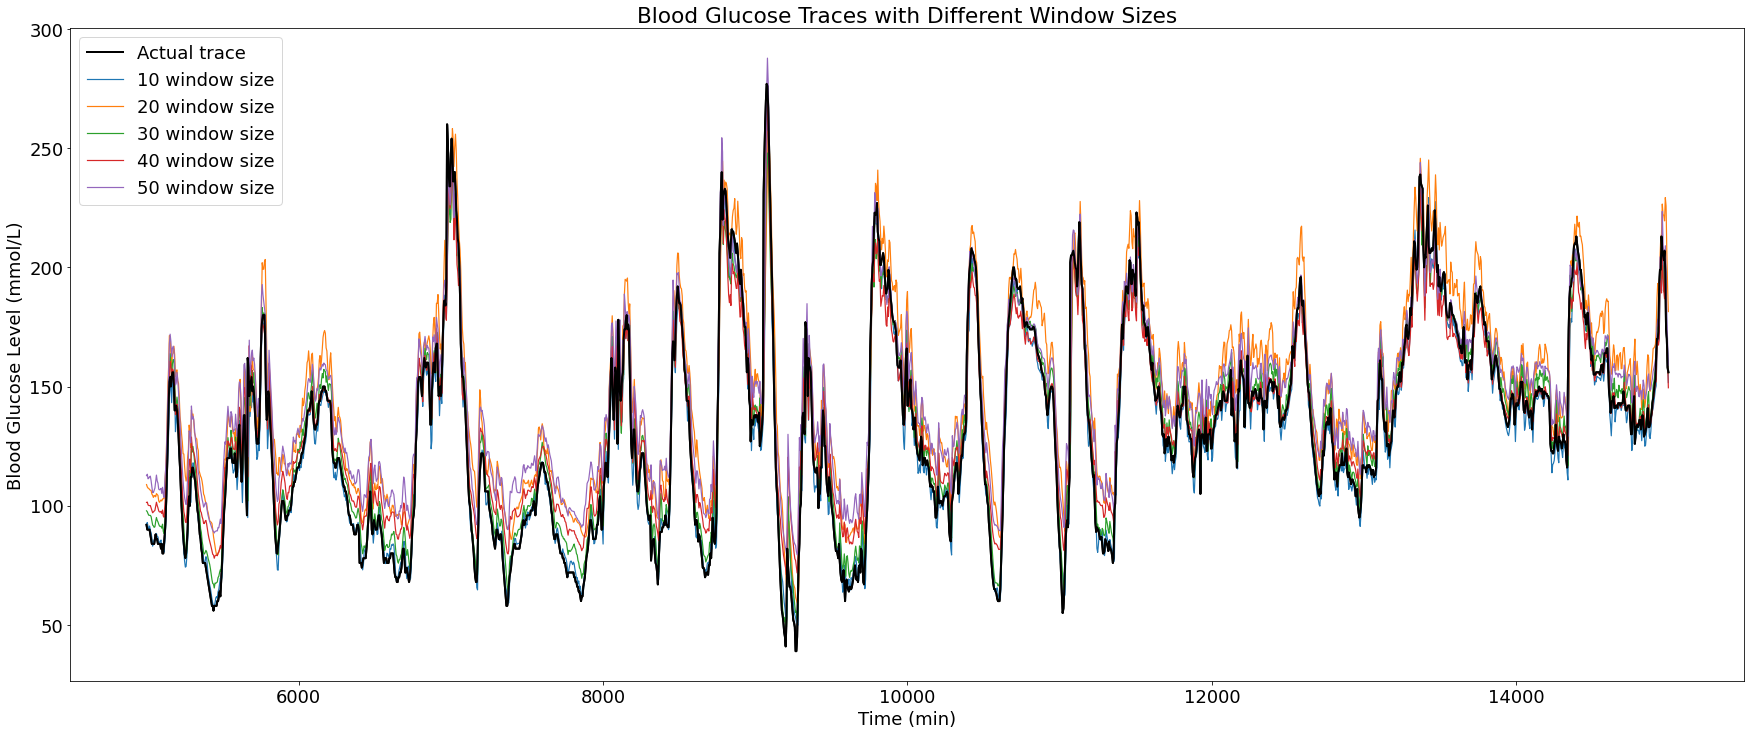

In [19]:
# Plot actual traces as proof of concept
fig, ax = plt.subplots(figsize=(30, 12))

# Plot different predictions on the same graph
time_values = list(range(5000, 15001, 5))
ax.plot(time_values, y_test[950:2951], linewidth=2.0, color='black', label='Actual trace')
for i in range(10, 51, 10):
  prediction = predictions[f'Window Size {i}']
  ax.plot(time_values, prediction[(1000-i):(3001-i)], label=f'{i} window size',
          linewidth=1.2)
ax.plot(time_values, y_test[950:2951], linewidth=2.0, color='black')

# Add labels
ax.set_ylabel('Blood Glucose Level (mmol/L)')
ax.set_xlabel('Time (min)')
ax.set_title('Blood Glucose Traces with Different Window Sizes')
ax.legend()

### **Part 4**: Save Data

In [21]:
# Prepare models
i = 1
for key in models.keys():
  model = models[key]
  model.model.save(f'width_test_{i}')
  i += 1

In [22]:
# Copy to drive
drive.mount('/content/drive')
!cp -r width_test_1/ "/content/drive/My Drive/"
!cp -r width_test_2/ "/content/drive/My Drive/"
!cp -r width_test_3/ "/content/drive/My Drive/"
!cp -r width_test_4/ "/content/drive/My Drive/"
!cp -r width_test_5/ "/content/drive/My Drive/"
!cp -r width_test_6/ "/content/drive/My Drive/"
!cp -r width_test_7/ "/content/drive/My Drive/"
!cp -r width_test_8/ "/content/drive/My Drive/"
!cp -r width_test_9/ "/content/drive/My Drive/"
!cp -r width_test_10/ "/content/drive/My Drive/"

Mounted at /content/drive
